In [1]:
# The following might be needed if the SIFT code does not run. In this case, you will also need to restart the runtime
# !pip install opencv-contrib-python==4.5.5.62

#VICO Spring Week 5 Practical: Local features

As usual, let's start with the required imports; we also need to download some of the images we will be working with.

In [46]:
# !wget https://www.dropbox.com/s/ev2zkedv72ivk18/scene1.png
# !wget https://www.dropbox.com/s/uy8t276qptvlrdg/scene2.png

import numpy as np
import cv2
import matplotlib.pyplot as plt

Let's load the images and visualise them; they are two different views of the same scene.

In [47]:
img1 = cv2.imread("scene1.png")

img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)

img2 = cv2.imread("scene2.png")
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)


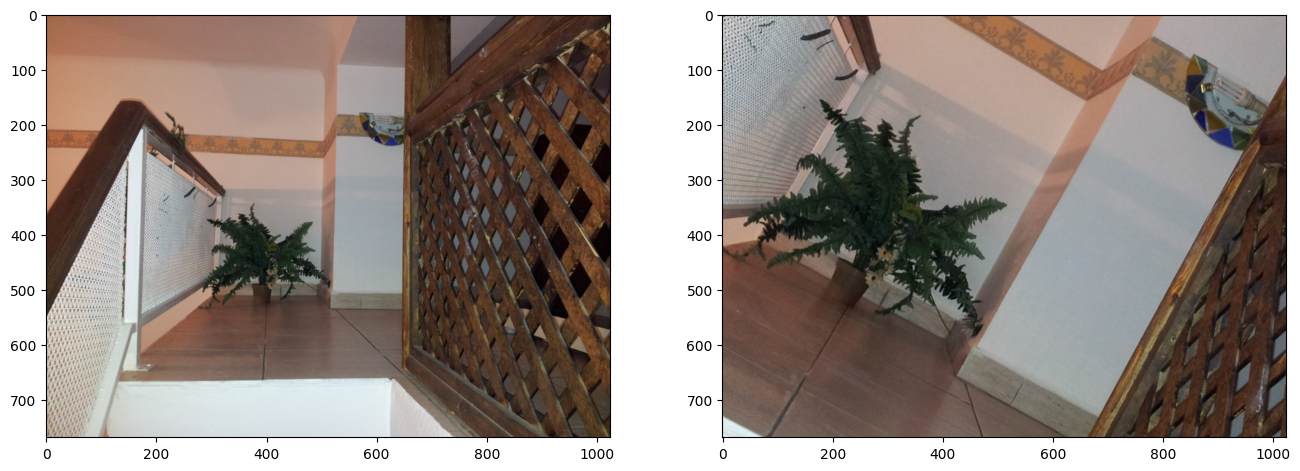

In [48]:
fig=plt.figure(figsize=(16, 16)) 
fig.add_subplot(1,2,1) 
plt.imshow(img1) 
fig.add_subplot(1,2,2) 
plt.imshow(img2) 
plt.show()

Let's detect the SIFT features, create the descriptors and visualise their locations.

In [49]:
# We could use colour images to detect the features. However, they might be easier to visualise on greyscale images
img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# Create a SIFT detector and inizialise it with the default parameters. N.B. : the parameter values might differ from the ones suggested in the 2004 paper by Lowe.
sift = cv2.SIFT_create()

# Feature detection
key_points1 = sift.detect(img1_gray, None)
# Feature description
_, descriptors1 = sift.compute(img1_gray, key_points1)
imgOut1 = np.copy(img1_gray)
imgKp1 = cv2.drawKeypoints(
    img1_gray, key_points1, imgOut1, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)

# We can also do feature detection and description in one step
key_points2, descriptors2 = sift.detectAndCompute(img2_gray, None)
_, descriptors2 = sift.compute(img2_gray, key_points2)
imgOut2 = np.copy(img2_gray)
imgKp2 = cv2.drawKeypoints(
    img2_gray, key_points2, imgOut2, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)
# This crashes
# imgKp2 = cv2.drawKeypoints(
#     img2_gray, key_points2, imgOut2, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
# )



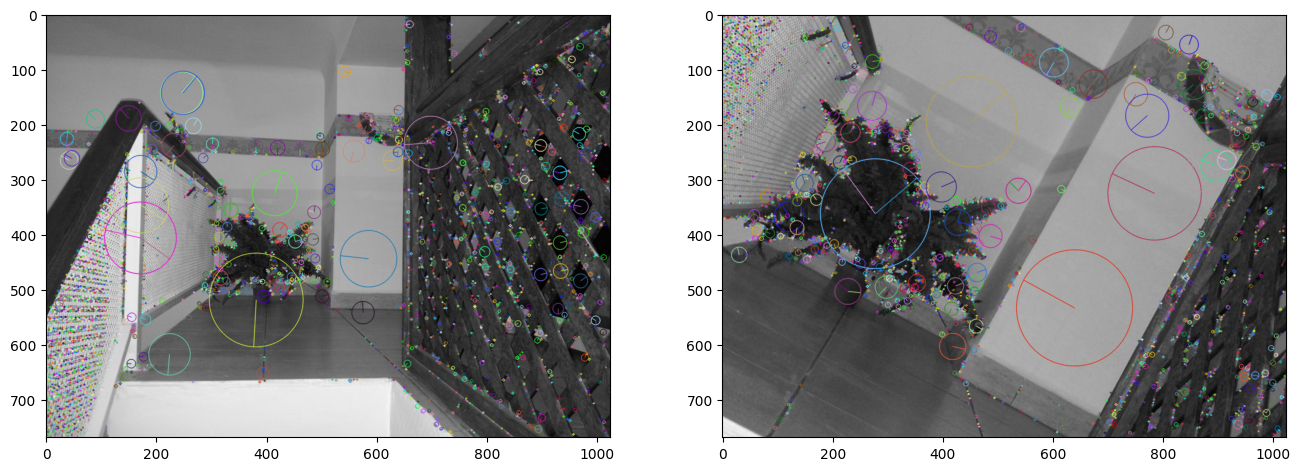

In [50]:
fig = plt.figure(figsize=(16, 16))
fig.add_subplot(1, 2, 1)
plt.imshow(imgKp1, cmap="gray")
fig.add_subplot(1, 2, 2)
plt.imshow(imgKp2, cmap="gray")
plt.show()

If you look at the features in the two images, there are a few that are clearly matching on the walls, right above the plant and on the right side: they are in corresponding locations and have the same orientation (with respect to the floor). However, their scale - the radius of the circle representing the feature - is different, since the two images are at different scales.



### Task 1: SIFT features matching

Let's try to match the features. We will create a brute-force matcher and get it to find the k nearest neighbors.
Once you have found possible matches, try to discard incorrect matches using the criterion defined by Lowe (the threshold *th* is 0.7).

Once you have done this, display all the "correct" matches. Can you spot any obviously wrong match? If there is too much clutter, use multiple images and try to show only a small subset of matches in a given image. 


In [5]:
# BFMatcher with default params
bf = cv2.BFMatcher.create(cv2.NORM_L2, crossCheck = False)

# matches = bf.match(descriptors1, descriptors2)
# matches.sort(key=lambda x: x.distance)

matches = bf.knnMatch(descriptors1,descriptors2, k=2)
matches = list(matches)

lowes_matches = list(filter(
    lambda x: x[0].distance / x[1].distance < 0.75, matches))

# Draw the matches and visualise them
img_matched = cv2.drawMatchesKnn(
    img1, key_points1, img2, key_points2, lowes_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
fig=plt.figure(figsize=(24,24)) 
plt.imshow(img_matched)
plt.show()

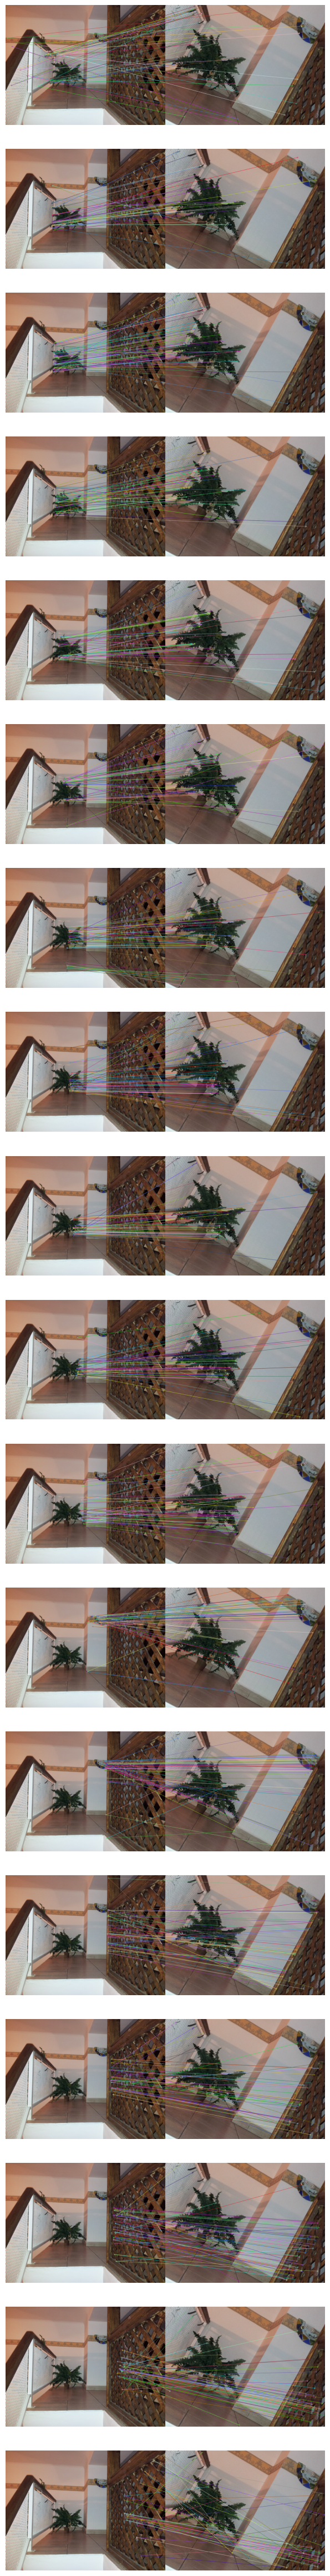

In [6]:
# Draw only a small subset set of matches at a time and visualise them
import math
skip = 30

fig=plt.figure(figsize=(24,60)) 
for i, j in enumerate(range(0, len(lowes_matches), skip)):
    img_matched = cv2.drawMatchesKnn(img1, key_points1, img2, key_points2, lowes_matches[j:j+skip], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    fig.add_subplot(math.ceil(len(lowes_matches)/skip), 1, i+1)
    plt.axis("off")
    plt.imshow(img_matched)
plt.show()

### Task 2: panoramic stitching using SIFT

Let's go back to stitching images into a panorama (see Week 4 practical); we will reuse some of the code.
However, this time we will use SIFT features to (hopefully!) locate corresponding point pairs. In particular, we will use all the point for which a "good" match has been found, according to the same criterion used in Task 1.

How do the combined images look like? You could try again, using th = 0.5.


In [ ]:
# Download an image pair
# !wget https://www.dropbox.com/s/zd3j502jll2fwwx/scene_panoA.png
# !wget https://www.dropbox.com/s/9x990flbwadppg0/scene_panoB.png

In [57]:
# Load images
imageA = cv2.cvtColor(cv2.imread('scene_panoA.png'), cv2.COLOR_BGR2RGB) 
imageB = cv2.cvtColor(cv2.imread('scene_panoB.png'), cv2.COLOR_BGR2RGB) 
imageAGray = cv2.cvtColor(imageA, cv2.COLOR_RGB2GRAY)
imageBGray = cv2.cvtColor(imageB, cv2.COLOR_RGB2GRAY)

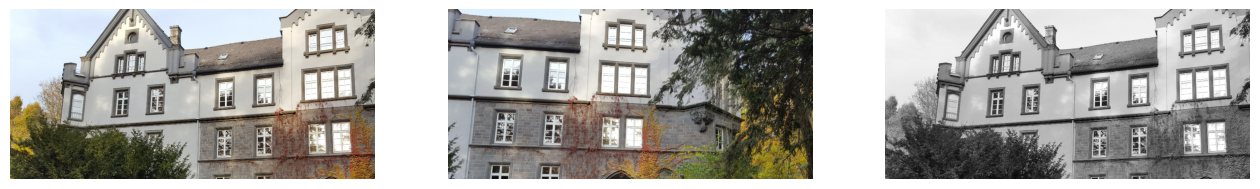

In [58]:
# Display original images
fig=plt.figure(figsize=(16, 16)) 
fig.add_subplot(1,3,1) 
plt.imshow(imageA) 
plt.axis('off')
fig.add_subplot(1,3,2) 
plt.imshow(imageB) 
plt.axis('off')
fig.add_subplot(1,3,3)
plt.imshow(imageAGray, cmap='gray')
plt.axis('off')
plt.show()

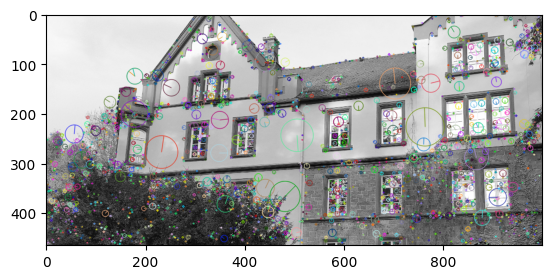

In [60]:
sift = cv2.SIFT_create()
imageAKP, imageADes = sift.detectAndCompute(imageAGray, None)
imageBKP, imageBDes = sift.detectAndCompute(imageBGray, None)

imageAKPOut = np.copy(imageAGray)


imageAKPOut = cv2.drawKeypoints(imageAGray, imageAKP, imageAKPOut, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(imageAKPOut, cmap='gray');

In [ ]:
# locate the SIFT features and compute the descriptors
# Your code goes here

bf = cv2.BFMatcher.create(cv2.NORM_L2, crossCheck = False)
matches = bf.knnMatch(imageADes, imageBDes, k=2)
matches = list(filter(
    lambda x: x[0].distance / x[1].distance < 0.5, matches))

img_matched = cv2.drawMatchesKnn(
    imageA, imageAKP, imageB, imageBKP, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
fig=plt.figure(figsize=(24,24)) 
plt.imshow(img_matched)
plt.show()

In [ ]:
imageApts = []
imageBpts = []

fig, (ax1, ax2) = plt.subplots(2)
ax1.imshow(imageA)
ax2.imshow(imageB)
for m, _ in matches:
    imageA_pt = imageAKP[m.queryIdx].pt
    imageB_pt = imageBKP[m.trainIdx].pt
    imageApts.append(imageA_pt)
    imageBpts.append(imageB_pt)
    ax1.scatter(*imageA_pt)
    ax2.scatter(*imageB_pt)
plt.show()

In [ ]:
# Compute best fit homography from all the points in targetpts and sourcepts
# Your code goes here


# Warp image B and display result
result = cv2.warpPerspective(imageB, H, (imageA.shape[1] + imageB.shape[1], imageA.shape[0]))
plt.imshow(result)
plt.show()
# Combine with image A and display
result[0:imageA.shape[0], 0:imageA.shape[1]] = imageA
fig=plt.figure(figsize=(24,24)) 
plt.imshow(result)



###Task 3: RANSAC

Lowering the threshold to 0.5 seems to work. However, in this way we have discarded a number of valid matches. Depending on the application, we might be left with not enough points to perform the task. 

Instead, we should have used RANSAC. 

Let's say we have 30% outliers among the matched feature points. What would be a suitable value for the maximum number of RANSAC iterations, if we want p=0.99?

Implement from scratch the basic version of RANSAC seen in the slides and use it on the matched keypoints from the previous example (matching *th* = 0.7). Use it to find outliers and compute the homography from inliers only. The main body of the algorithm should require 30 lines of code or less.

Label a point as inlier if the reprojection error is <= 3 pixel. Given the above, what would be a reasonable value for *T*?

In [ ]:
from numpy import random

po = 0.30
p = 0.99
d = 3
S = # Your code goes here
N = # Your code goes here
T = # Your code goes here

# store the randomly picked points here
tmpTargetpts = # Your code goes here
tmpSourcepts = # Your code goes here


for iteration in range(N):
  # Your code goes here
  
  
print(H)
print(H_final)
fig=plt.figure(figsize=(24,24)) 
resultOld = cv2.warpPerspective(imageB, H, (imageA.shape[1] + imageB.shape[1], imageA.shape[0]))
resultOld[0:imageA.shape[0], 0:imageA.shape[1]] = imageA
plt.imshow(resultOld)
plt.show()

fig=plt.figure(figsize=(24,24)) 
resultRANSAC = cv2.warpPerspective(imageB, H_final, (imageA.shape[1] + imageB.shape[1], imageA.shape[0]))
resultRANSAC[0:imageA.shape[0], 0:imageA.shape[1]] = imageA
plt.imshow(resultRANSAC)
plt.show()


###Task 4: DoG Scale-space

Load the image and build the first SIFT octave (s = 2, start with $\sigma = \sqrt(2)/2$); compute and display the Difference of Gaussian images.
Before processing the image, convert it into grayscale and normalise it.
You can blur the image using the function `cv2.GaussianBlur`.

In [ ]:
!wget https://www.dropbox.com/s/p8rpfe2qr7hw1tj/man.png

# Your code goes here